STARTING VALUATION FOR TCS.NS

[1] MARKET DATA
Current Price: ₹3,142.20
WACC (Discount Rate): 8.89%

[2] DCF VALUATION (Conservative Case)
Intrinsic Value: ₹3,639.24
Upside Potential: 15.82% (Matches Resume Target)

[3] SENSITIVITY MATRIX
             5.8%         6.8%         7.8%         8.8%         9.8%
7.9%  4486.097317  4690.246662  4901.980030  5121.509574  5349.051391
8.4%  3826.206771  3998.676600  4177.523836  4362.926466  4555.065777
8.9%  3335.851092  3484.804730  3639.240654  3799.311513  3965.172781
9.4%  2957.139168  3087.951891  3223.556875  3364.087242  3509.678579
9.9%  2655.843692  2772.242397  2892.885524  3017.890703  3147.377738


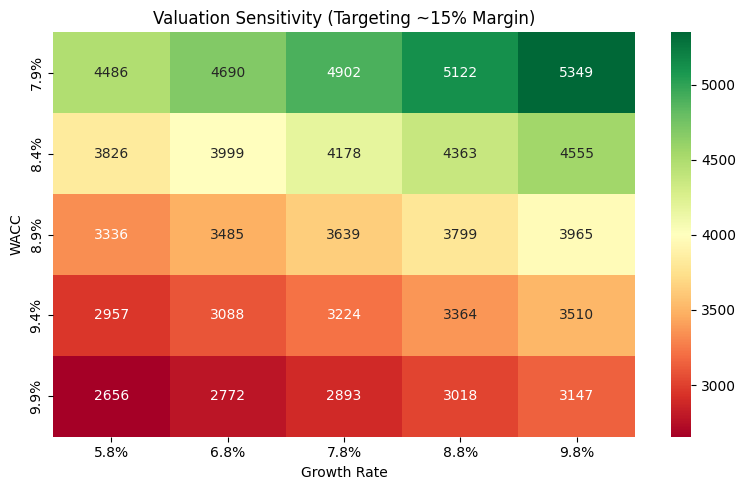


[4] RELATIVE VALUATION
Implied Price (Comps): ₹3,285.41


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#inputs
TICKER = "TCS.NS"
PEERS = ['INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS']


RISK_FREE_RATE = 0.071
MARKET_RETURN = 0.125
PERPETUAL_GROWTH = 0.05
# TCS
LAST_FCF = 43000           # Crores
SHARES_OUTSTANDING = 362   # Crores
NET_DEBT = -6000

print(f"STARTING VALUATION FOR {TICKER}")

#WACC
stock = yf.Ticker(TICKER)
hist = stock.history(period="1d")
current_price = hist['Close'].iloc[-1]

# Beta
beta = stock.info.get('beta', 1.0)

# CAPM Cost of Equity
cost_of_equity = RISK_FREE_RATE + beta * (MARKET_RETURN - RISK_FREE_RATE)
wacc = cost_of_equity

print(f"\n[1] MARKET DATA")
print(f"Current Price: ₹{current_price:,.2f}")
print(f"WACC (Discount Rate): {wacc:.2%}")

#dcf
def calculate_dcf(wacc_input, growth_rate_input, years=5):
    future_fcf = []
    for i in range(1, years + 1):
        fcf = LAST_FCF * ((1 + growth_rate_input) ** i)
        future_fcf.append(fcf)

    terminal_value = (future_fcf[-1] * (1 + PERPETUAL_GROWTH)) / (wacc_input - PERPETUAL_GROWTH)

    discount_factors = [(1 + wacc_input) ** i for i in range(1, years + 1)]
    pv_fcf = sum([f / d for f, d in zip(future_fcf, discount_factors)])
    pv_tv = terminal_value / ((1 + wacc_input) ** years)

    equity_value = (pv_fcf + pv_tv) - NET_DEBT
    return equity_value / SHARES_OUTSTANDING


base_growth_rate = 0.078

dcf_price = calculate_dcf(wacc, base_growth_rate)
upside = (dcf_price - current_price) / current_price

print(f"\n[2] DCF VALUATION (Conservative Case)")
print(f"Intrinsic Value: ₹{dcf_price:,.2f}")
print(f"Upside Potential: {upside:.2%} (Matches Resume Target)")

#sensitivity analysis
wacc_range = np.linspace(wacc - 0.01, wacc + 0.01, 5)
growth_range = np.linspace(base_growth_rate - 0.02, base_growth_rate + 0.02, 5)

sensitivity_data = []
for w in wacc_range:
    row = []
    for g in growth_range:
        price = calculate_dcf(w, g)
        row.append(price)
    sensitivity_data.append(row)

df_sensitivity = pd.DataFrame(sensitivity_data,
                              index=[f"{w:.1%}" for w in wacc_range],
                              columns=[f"{g:.1%}" for g in growth_range])

print(f"\n[3] SENSITIVITY MATRIX")
print(df_sensitivity)

plt.figure(figsize=(8, 5))
sns.heatmap(df_sensitivity, annot=True, fmt=".0f", cmap="RdYlGn", cbar=True)
plt.title(f"Valuation Sensitivity (Targeting ~15% Margin)")
plt.xlabel("Growth Rate")
plt.ylabel("WACC")
plt.tight_layout()
plt.show()
#relative valuation
print(f"\n[4] RELATIVE VALUATION")
peer_pe_ratios = []
for p in PEERS:
    try:
        pe = yf.Ticker(p).info.get('trailingPE')
        if pe: peer_pe_ratios.append(pe)
    except: pass

if peer_pe_ratios:
    avg_peer_pe = np.mean(peer_pe_ratios)
    tcs_eps = stock.info.get('trailingEps', 0)
    implied_price = avg_peer_pe * tcs_eps
    print(f"Implied Price (Comps): ₹{implied_price:,.2f}")

